In [1]:
import numpy as np
import torch
from torch.optim import lr_scheduler
import gym
from agent import PPO
import os, shutil
from datetime import datetime
import matplotlib.pyplot as plt
import time 

### Helper functions

In [2]:
def evaluate_policy(env, model, render, steps_per_epoch):
    scores = 0
    turns = 3
    for j in range(turns):
        s, done, ep_r, steps = env.reset(), False, 0, 0
        while not (done or (steps >= steps_per_epoch)):
            # Take deterministic actions at test time
            a, logprob_a = model.evaluate(s)
            act = lambda a: 2 * (a-0.5)*env.action_space.high[0]
            s_prime, r, done, info = env.step(act(a))

            ep_r += r
            steps += 1
            s = s_prime
            if render:
                env.render()
        scores += ep_r
    return scores/turns


def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    
    plt.plot(x, running_avg, label="Running average")
    plt.plot(x, scores, alpha=0.2)
    plt.title('Learning plot')
    plt.xlabel("Runs")
    plt.ylabel("Scores")
    plt.legend(loc="best")


### Main training

EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 0k score: -210.31170567267267
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 10k score: -272.28328215052943
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 20k score: -290.0994049143467
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 30k score: -311.10717645498556
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 40k score: -251.30939145475136
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 50k score: -340.88604414673375
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 60k score: -319.3946561146104
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 70k score: -269.6265755032981
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 80k score: -222.30831666007998
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 90k score: -198.1356176166254
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 100k score: -256.7803210868639
EnvName:  LunarLanderContinuous-v2 seed: 1 steps: 110k score: -119.25887158795932
EnvName:  LunarLanderContinuous-

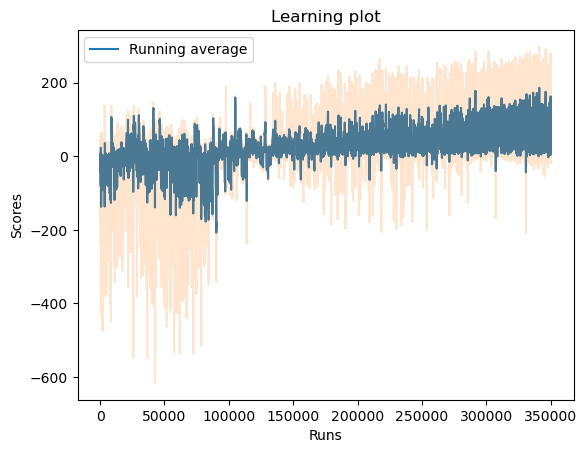

In [3]:
def main():
    render = False

    random_seed = 1
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # Environment
    env_name = "LunarLanderContinuous-v2"
    env = gym.make(env_name)
    env.seed(random_seed)
    
    # Evaluation environment
    eval_env = gym.make(env_name)
    eval_env.seed(random_seed)

    
    # Hyperparameters
    kwargs = {
        "state_dim": env.observation_space.shape[0], 
        "action_dim": env.action_space.shape[0], 
        "env_with_Dead": False,
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
        "clip_rate": 0.2, 
        "n_epochs": 10, 
        "net_width": 150, 
        "lr": 3.0e-4,
        "l2_reg": 1e-3,
        "dist": "Beta" ,
        "optim_batch_size": 64, 
        "entropy_coef": 1e-3,
        "entropy_coef_decay": 0.99
        }

    
    N = 2048 # lenth of long trajectory
    max_steps = env._max_episode_steps
    Max_train_steps = 350e3
    save_interval = 15e3
    eval_interval = 10e3
    best_interval = 200e3

    score_history = []

    total_steps = 0
    traj_length = 0
    best_score = -10000
    
    
    model = PPO(**kwargs)

    if not os.path.exists('model'): 
        os.mkdir('model')
    if not os.path.exists('best_model'): 
        os.mkdir('best_model')
    
    
    while total_steps < Max_train_steps:
        observation, done, steps, score = env.reset(), False, 0, 0

        '''Interact & trian'''
        while not done:
            steps += 1
            traj_length += 1

            action, probs = model.select_action(observation)
            act = lambda a: 2 * (a-0.5)*env.action_space.high[0]  #Action adapter [0,1] to [-max,max]
            observation_, reward, done, info = env.step(act(action))

            if (done and steps != max_steps):
                dw = True  #dw: dead and win
            else:
                dw = False
            
            model.put_data((observation, action, reward, observation_, probs, done, dw))
            observation = observation_
            score += reward 

            score_history.append(score)
            avg_score = np.mean(score_history[-100:]) 

            '''update if its time'''
            if traj_length % N == 0:
                model.train()
                traj_length = 0               
    
            '''record & log'''
            if total_steps % eval_interval == 0:
                ss = evaluate_policy(eval_env, model, False, max_steps)
                print('EnvName: ',env_name, 'seed:',random_seed,'steps: {}k'.format(int(total_steps/1000)),'score:', ss)
            total_steps += 1

            '''save model'''
            if total_steps % save_interval==0:
                model.save(total_steps)           
           
            ''' best model '''
            if total_steps >= best_interval:
                if score_history[-1] > best_score:
                    best_score = score_history[-1]
                    model.best_save()


    env.close()
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history)

if __name__ == '__main__':
    start_time = time.time()
    main()
    end_time = time.time()
    final_time = end_time - start_time
    print(final_time)

### Model testing

In [5]:
# Hyperparameters
env = gym.make("LunarLanderContinuous-v2")

kwargs = {
    "state_dim": env.observation_space.shape[0], 
    "action_dim": env.action_space.shape[0], 
    "env_with_Dead": False,
    "gamma": 0.99, 
    "gae_lambda": 0.95, 
    "clip_rate": 0.2, 
    "n_epochs": 10, 
    "net_width": 150, 
    "lr": 2.0e-4,
    "l2_reg": 1e-3,
    "dist": "Beta" ,
    "optim_batch_size": 64, 
    "entropy_coef": 0,
    "entropy_coef_decay": 0.
    }

model = PPO(**kwargs)

model.load_best()
scores = []


for i in range(20):
    obs = env.reset()
    actions = []
    score = 0
    while True:
        action, prob = model.evaluate(obs)
        act = lambda a: 2 * (a-0.5)*env.action_space.high[0]  #Action adapter [0,1] to [-max,max]
        obs, reward, done, info = env.step(act(action))
        score += reward
        actions.append(action)

        if done:
            print(f"Done, points: {score}")
            break
    
    scores.append(score)

print(f"Mean score: {np.mean(scores)}")

Done, points: 251.2531395211533
Done, points: 252.31707057620193
Done, points: 242.7155419103009
Done, points: 250.26756679363388
Done, points: 212.00362077252558
Done, points: -16.8330074532455
Done, points: 178.8815829157511
Done, points: 235.9124402409238
Done, points: 259.1751908843596
Done, points: 255.87340711094058
Done, points: 268.2269778312494
Done, points: 238.2743519060585
Done, points: 219.20633827742824
Done, points: -15.76676012918017
Done, points: 267.55154058443543
Done, points: 259.33840468942617
Done, points: 250.73140670816562
Done, points: 257.32369218646465
Done, points: -38.72311372886209
Done, points: 301.28068429003827
Mean score: 206.45050379438845
